In [48]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import imblearn

In [31]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from scipy.stats import kurtosis, skew
from scipy import stats

# 1. Reading Input data

In [8]:
FILE_PATH = 'C:/Users/hp/python files/oil-spill.csv'

oil_df = pd.read_csv(FILE_PATH, header=None)

# Dropping unused columns
oil_df.drop([0,22], axis=1, inplace=True)

In [37]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def CalOutliers(df_num): 
    '''
    
    Leonardo Ferreira 20/10/2018
    Set a numerical value and it will calculate the upper, lower and total number of outliers
    It will print a lot of statistics of the numerical feature that you set on input
    
    '''
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print(color.BOLD+f'Lower outliers: {len(outliers_lower)}'+ color.END) # printing total number of values in lower cut of outliers
    print(color.BOLD+f'Upper outliers: {len(outliers_higher)}'+ color.END) # printing total number of values in higher cut of outliers
    print(color.BOLD+f'Total outliers: {len(outliers_total)}'+ color.END) # printing total number of values outliers of both sides
    print(color.BOLD+f'Non - outliers: {len(outliers_removed)}'+ color.END) # printing total number of non outlier values
    print(color.BOLD+f'% of Outliers : {round((len(outliers_total) / len(outliers_removed) )*100, 4)}'+ color.END ) # Percentual of outliers in points

# 2. Exploring Data


In [11]:
DataDesc(oil_df)

Dataset Shape: (937, 48)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,1,int64,0,297,2558.00,22325.00,115.00,7.33
1,2,float64,0,927,1506.09,79.11,1449.85,9.85
2,3,float64,0,933,456.63,841.03,608.43,9.86
3,4,int64,0,179,90.00,180.00,88.00,7.16
4,5,float64,0,375,6395000.00,55812500.00,287500.00,7.66
5,6,float64,0,820,40.88,51.11,40.42,9.61
6,7,float64,0,618,7.89,1.21,7.34,9.09
7,8,float64,0,561,29780.00,61900.00,3340.00,8.72
8,9,float64,0,57,0.19,0.02,0.18,4.98
9,10,float64,0,577,214.70,901.70,86.10,8.88


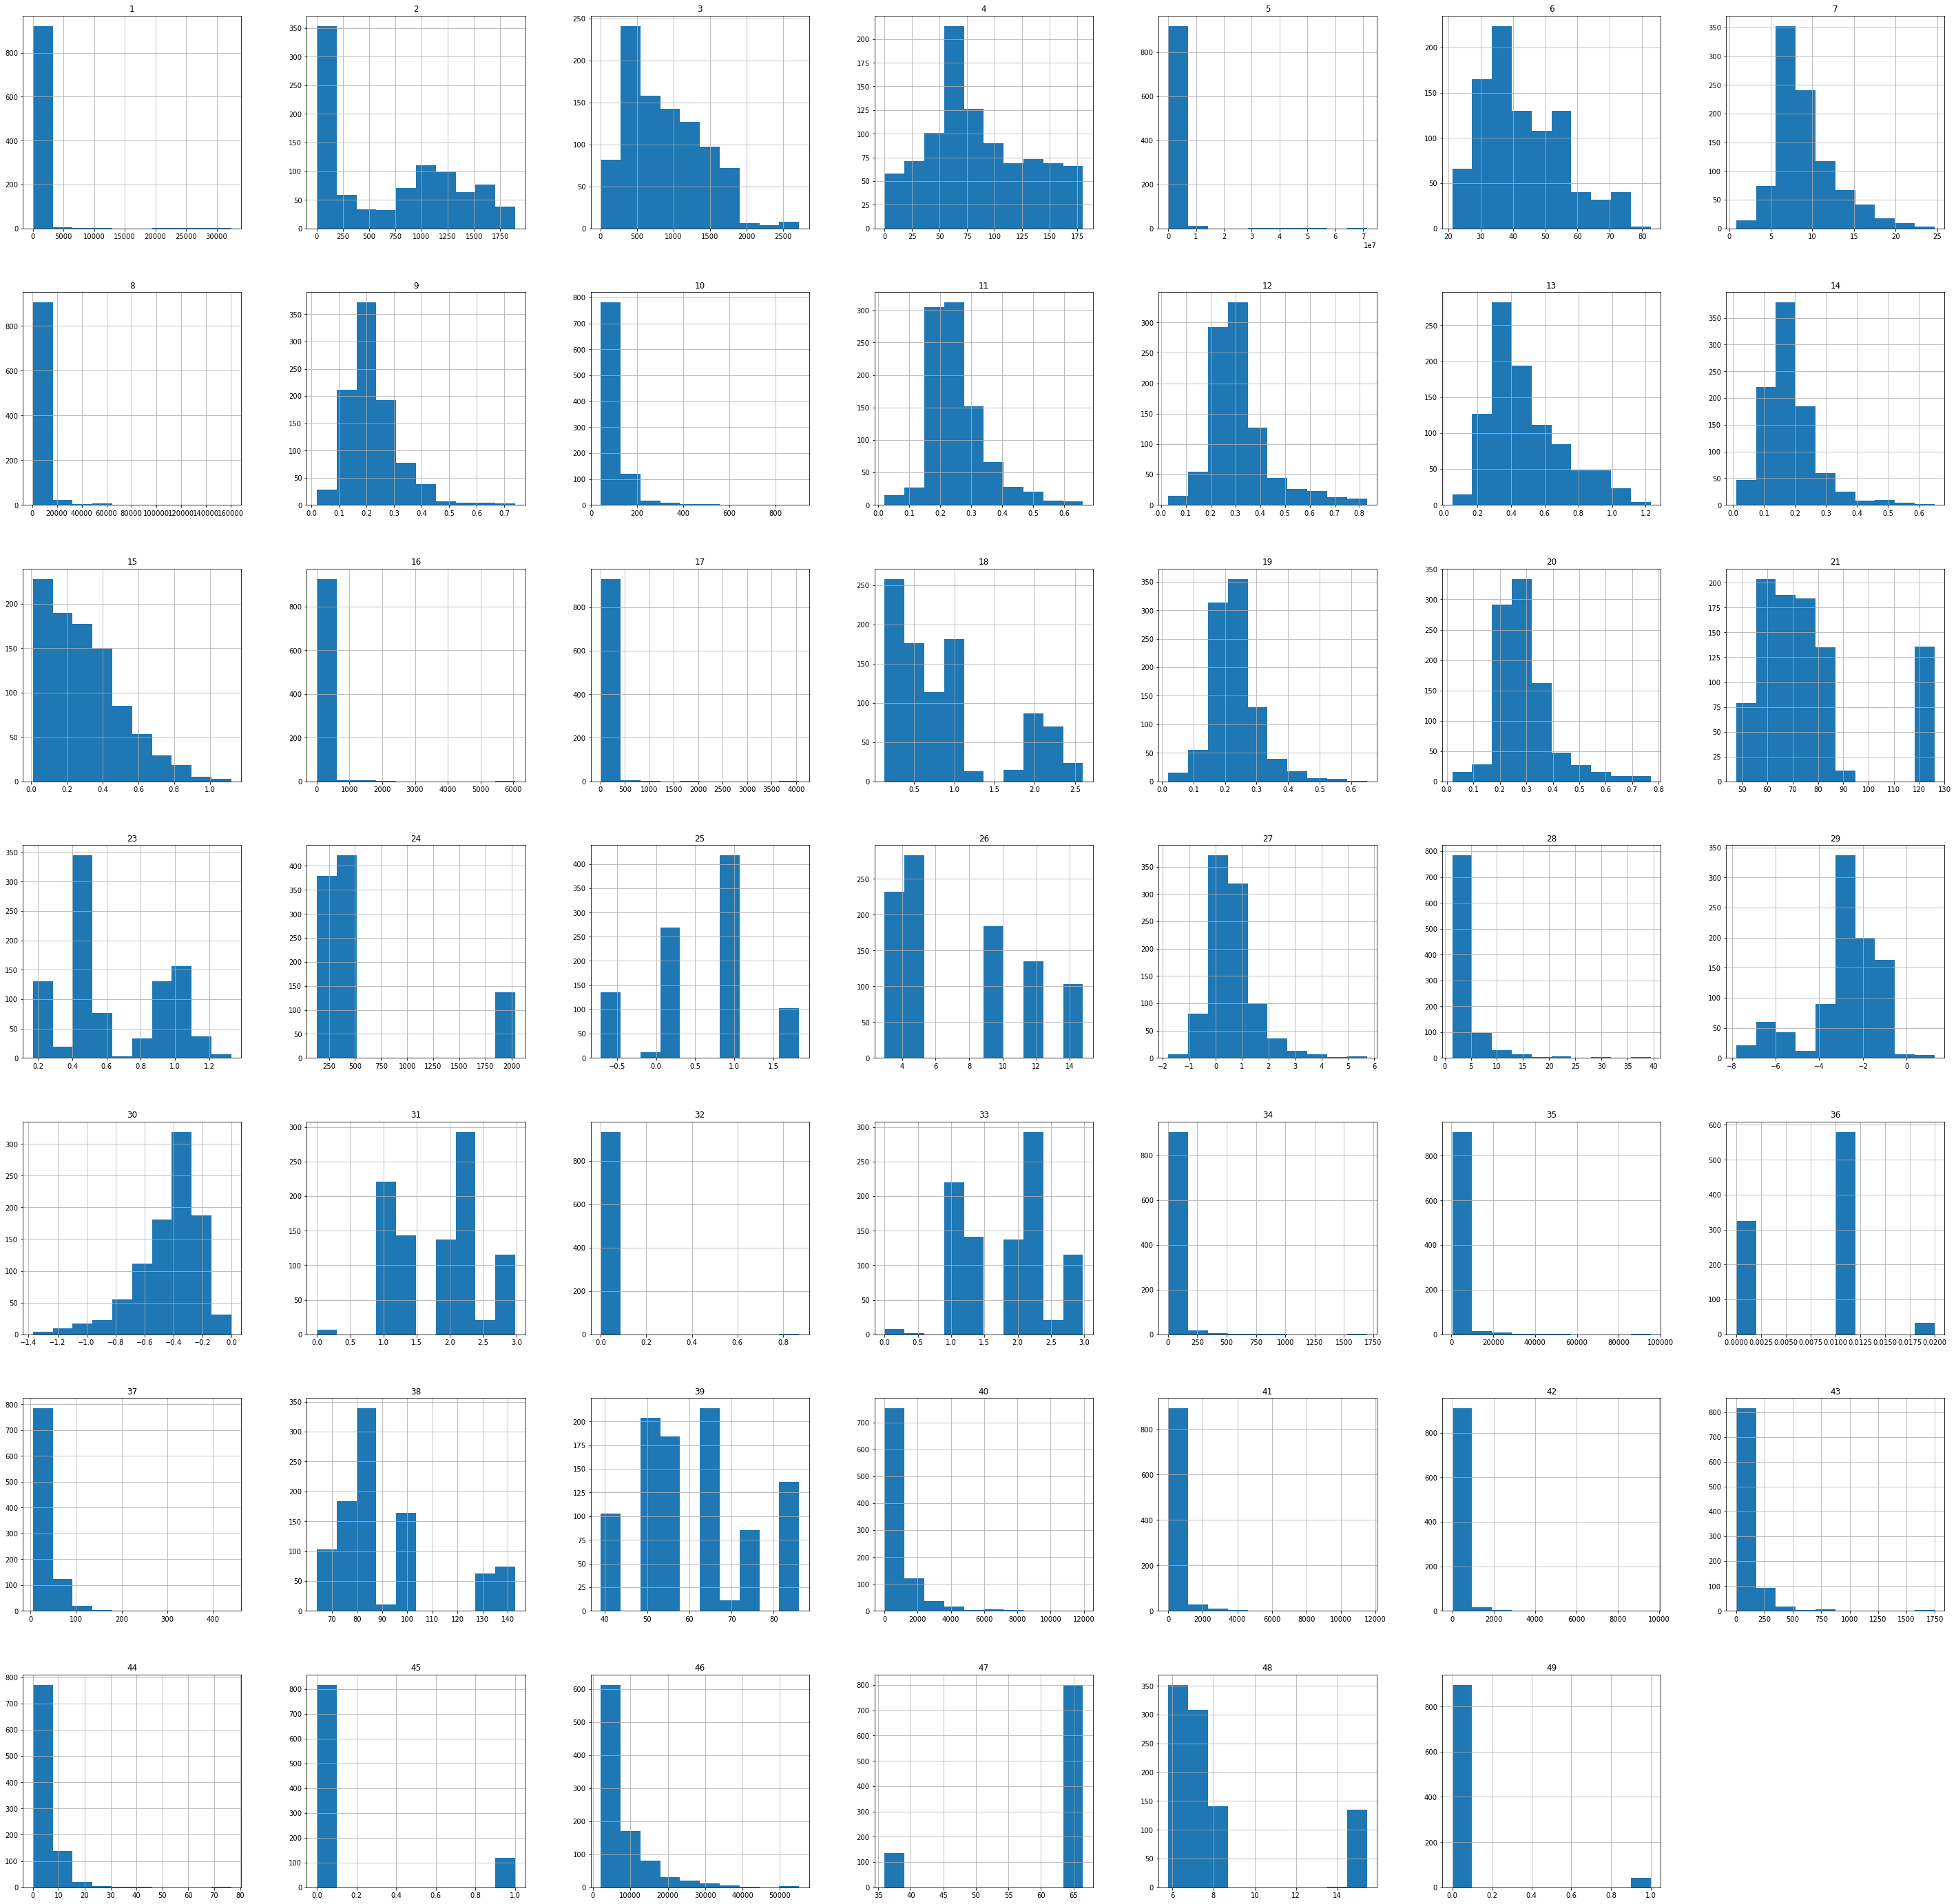

In [12]:
fig = plt.figure(figsize=(50,50))
ax = fig.gca()

_ = oil_df.hist(ax=ax)

Class=1, Count=41, Percentage=4.376%
Class=0, Count=896, Percentage=95.624%


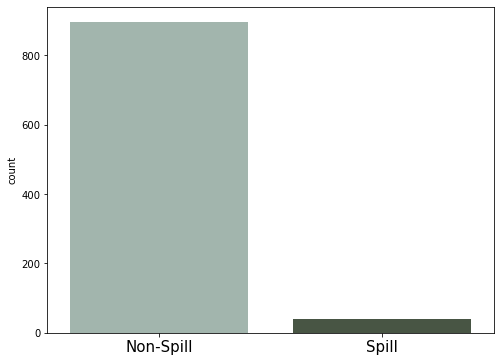

In [40]:
_ = plt.figure(figsize=(8,6))
_ = sns.countplot(oil_df.values[:,-1], palette=['#9fb8ad','#475841'])
_ = plt.xticks([0,1],['Non-Spill','Spill'], fontsize=15)

target = oil_df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

# 3. Model Test & Baseline Result


In [41]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    metric = make_scorer(geometric_mean_score)
    
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    
    return scores

X, y = oil_df.values[:,:-1], oil_df.values[:,-1]

print(X.shape, y.shape, Counter(y))

model = DummyClassifier(strategy='uniform')

scores = evaluate_model(X, y, model)

print('Mean G-Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


(937, 47) (937,) Counter({0.0: 896, 1.0: 41})
Mean G-Mean: 0.500 (0.113)


# 4. Evaluate Models 

# 4.1. Probabilistic models 

In [15]:
def get_models():
    models, names = list(), list()
    # LR
    steps = [('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))] 
    models.append(Pipeline(steps=steps))
    names.append('LR')
    
    # LDA
    steps = [('t', StandardScaler()),('m',LinearDiscriminantAnalysis())] 
    models.append(Pipeline(steps=steps))
    names.append('LDA')
    
    # NB
    models.append(GaussianNB())
    names.append('NB')
    
    return models, names


models, names = get_models()

results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.672 (0.203)
>LDA 0.755 (0.147)
>NB 0.707 (0.202)


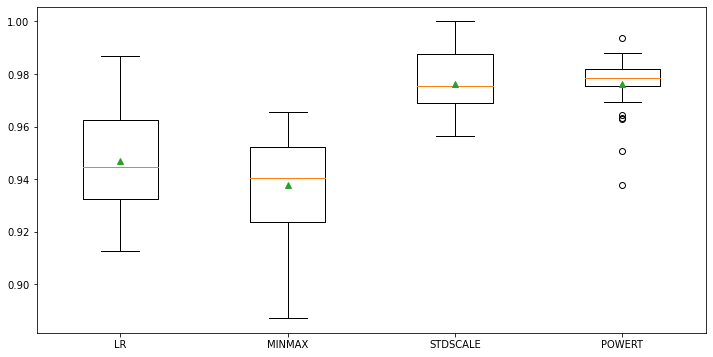

In [42]:
plt.figure(figsize=(12,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# 4.2. Evaluate balanced Logistic Regression

In [17]:
def get_models():
    names, models = list(), list()
    
    #LR balanced
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
    names.append('Balanced')
        
    #LR MinMax
    steps = [('MinMax', MinMaxScaler()),('model',LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-MinMax')
    
    #LR StandardScale
    steps = [('StandScale', StandardScaler()),('model',LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Standard')   
    
    #LR Scale + Power Transform
    steps = [('StandScale', MinMaxScaler()),('pt',PowerTransformer()), ('model',LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-PowerTransform')
    
    return models, names


models, names = get_models()

results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Balanced 0.843 (0.112)
>Balanced-MinMax 0.836 (0.088)
>Balanced-Standard 0.834 (0.129)
>Balanced-PowerTransform 0.862 (0.124)


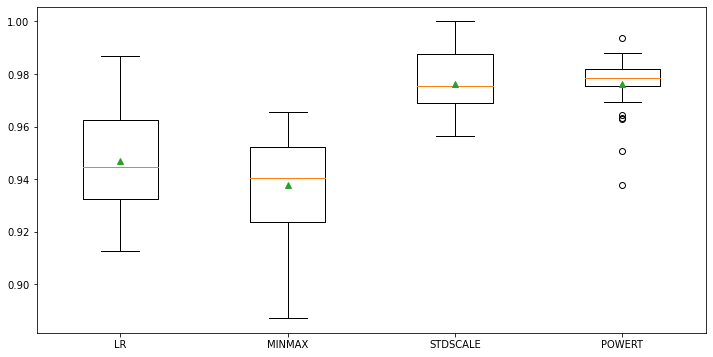

In [43]:
plt.figure(figsize=(12,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# 4.3. Evaluate Damp-Sampling with Probablistic models

In [19]:
def get_sampled_data(X, y, name):
    
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    
    if(name == 'LR'):
        X_s, y_s = sampling.fit_resample(X, y)
        
    elif(name == 'MINMAX'):
        scaler = MinMaxScaler()
        X_scale = scaler.fit_transform(X)
        X_s, y_s = sampling.fit_resample(X_scale, y)
    
    elif(name == 'STDSCALE'):
        scaler = StandardScaler()
        X_scale = scaler.fit_transform(X)
        X_s, y_s = sampling.fit_resample(X_scale, y)
    
    elif(name == 'POWERT'):
        scaler = MinMaxScaler()
        powert = PowerTransformer()
        X_scale = scaler.fit_transform(X)
        X_t = powert.fit_transform(X_scale)
        X_s, y_s = sampling.fit_resample(X_t, y)   
    
    return X_s, y_s


In [20]:
def evaluate_model(X, y):
    
    model = LogisticRegression(solver='liblinear')
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    metric = make_scorer(geometric_mean_score)
    
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    
    return scores

In [21]:
results = list()

for name in ['LR', 'MINMAX', 'STDSCALE', 'POWERT']:
    X_s, y_s = get_sampled_data(X, y, name)
    scores = evaluate_model(X_s, y_s)
    results.append(scores)
    
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>LR 0.947 (0.019)
>MINMAX 0.938 (0.018)
>STDSCALE 0.976 (0.012)
>POWERT 0.976 (0.011)


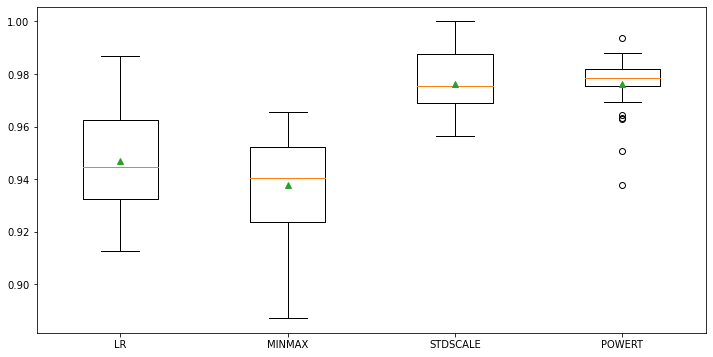

In [44]:
names = ['LR', 'MINMAX', 'STDSCALE', 'POWERT']

plt.figure(figsize=(12,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# 5. Fitting Model

In [23]:
from sklearn.model_selection import train_test_split

X_s, y_s = get_sampled_data(X, y, 'POWERT')
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.1, stratify=y_s, random_state=1)

model = LogisticRegression(solver='lbfgs')

c_values = [10000, 1000, 800, 500, 100, 10, 1.0, 0.1, 0.01, 0.001]
grid = dict(C=c_values)

metric = make_scorer(geometric_mean_score)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring=metric,error_score=0)

grid_result = grid_search.fit(X_s, y_s)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.985170 using {'C': 10000}


In [45]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = grid_result.best_estimator_

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[83  0]
 [ 0 90]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        83
         1.0       1.00      1.00      1.00        90

    accuracy                           1.00       173
   macro avg       1.00      1.00      1.00       173
weighted avg       1.00      1.00      1.00       173



# 6. ROC Curve


In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=1.000000, G-mean=1.000


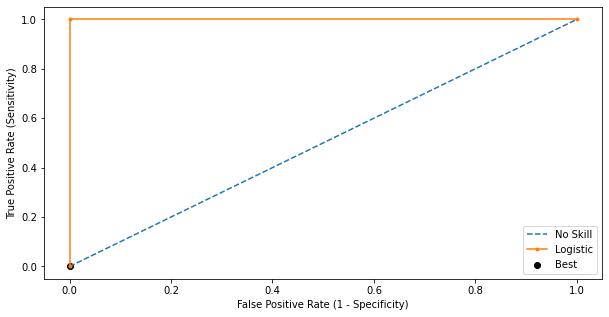

In [46]:
plt.figure(figsize=(10,5))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill') 

plt.plot(fpr, tpr, marker='.', label='Logistic') 
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best') 
# axis labels
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
# show the plot
plt.show()

# 7. Precision Recall Curve


In [27]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

#Calculate f-Score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest g-mean
ix = np.argmax(fscore)

print('Best Threshold=%f, F-score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=1.000000, F-score=1.000


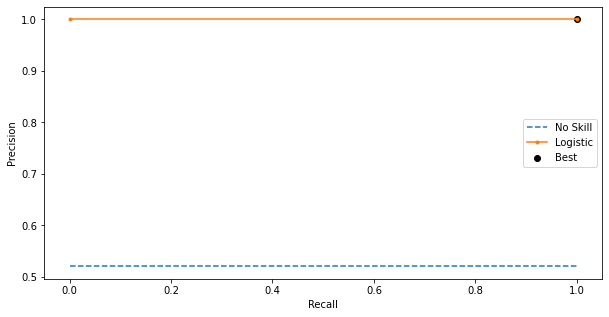

In [47]:
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(10,5))
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill') 
plt.plot(recall, precision, marker='.', label='Logistic') 
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best') 
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# 8. Confusion Matrix

In [29]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


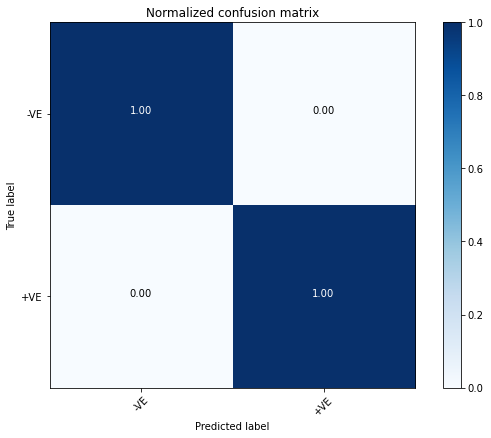

In [30]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['-VE','+VE']
np.set_printoptions(precision=2)


plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')